In [361]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

import numpy as np
import scipy.stats as stats
import pandas as pd

from scipy.spatial import distance
from sklearn.cluster import SpectralBiclustering
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import pickle
import nltk

import drawing_utils as drawing

In [351]:
experiment_name = 'perceptual_chunks'

## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

# paths to silhouette data
silhouette_results_dir = os.path.join(results_dir, 'silhouette')
silhouette_csv_dir = os.path.join(silhouette_results_dir,'csv')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [332]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['perceptual_chunks']

# latest iteration name to include
iteration_name = 'pilot_0c'
iteration_names = ['pilot_0','pilot_0b','pilot_0c']

# variables to check integrity of data
numTrials = 8

In [99]:
# load csvs outputted from data generator

# trial_path = os.path.join(csv_dir,'perceptual_chunks_trial_{}.csv'.format(iteration_name))
# df_trial = pd.read_csv(trial_path)

# color_path = os.path.join(csv_dir,'perceptual_chunks_color_{}.csv'.format(iteration_name))
# df_color = pd.read_csv(trial_path)

In [100]:
# open pickled dataframes

trial_path_p = os.path.join(csv_dir,'perceptual_chunks_trial_{}.p'.format(iteration_name))
df_trial = pickle.load( open(trial_path_p, "rb" ))

color_path_p = os.path.join(csv_dir,'perceptual_chunks_color_{}.p'.format(iteration_name))
df_color = pickle.load( open(color_path_p, "rb" ))

In [51]:
# useful vars
ppts = np.sort(df_trial.gameID.unique())
targets = np.sort(df_trial.targetName.unique())
n_ppt = len(ppts)

## Visualizations

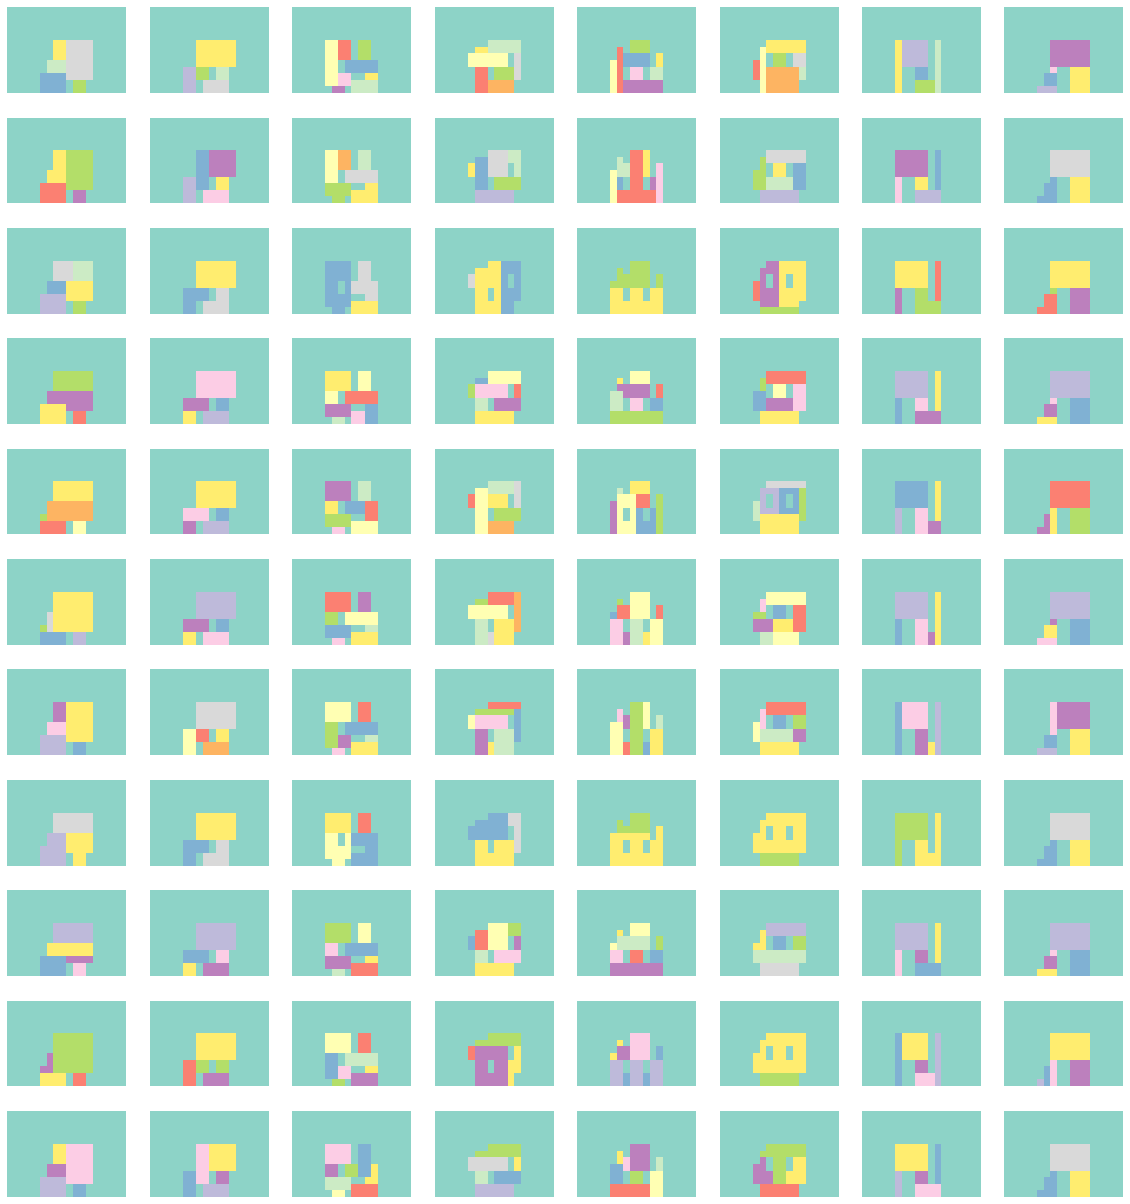

In [101]:
# visualize all participant's chunks

fig, axs = plt.subplots(n_ppt, numTrials, figsize=(20,2*n_ppt))

for i, ppt in enumerate(ppts):

    for j, target in enumerate(targets):

        chunks = df_trial[(df_trial.gameID==ppt) & (df_trial.targetName==target)]['gameGrid'].iloc[0]
        chunks = np.rot90(chunks)
        axs[i,j].axis('off')
        axs[i,j].imshow(chunks, cmap='Set3')

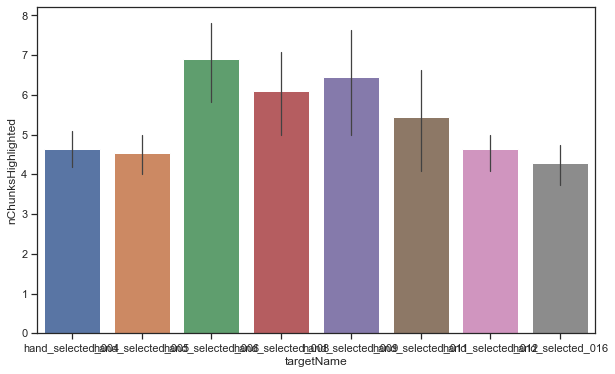

In [52]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.barplot(data=df_trial, y='nChunksHighlighted',x='targetName', order=targets)

In [ ]:
# visualize all participant's chunks

fig, axs = plt.subplots(n_ppt, numTrials, figsize=(20,2*n_ppt))

for i, ppt in enumerate(ppts):

    for j, target in enumerate(targets):

        chunks = df_trial[(df_trial.gameID==ppt) & (df_trial.targetName==target)]['structureGrid'].iloc[0]
        chunks = np.rot90(chunks)
        axs[i,j].axis('off')
        axs[i,j].imshow(chunks, cmap='Set3')

## Perceptual chunk analysis notes


### Properties of the chunk painting process
- size of chunk colored in over time
    - distinguish adding to the same chunk from creating new ones
- average position of colored square over trial
    - is it bottom to top?

### Simple properties of perceptual chunks as predictors of difficulty/ complexity
- Number of perceptual chunks in each structure, as a measure of (perceptual) complexity
- Proportion of perceptual chunks that can't be made with blocks provided (as a measure of difficulty)
- Variance in perceptual chunks as a measure of 'knowing what to do first' when building (e.g. thinking time pre first block)
    - calculate using edit distance below

### Strategies for comparing perceptual chunks with procedural chunks

Within *perceptual* chunks:
- Find an edit distance
    - cost: +1 for changing a square, 0 for changing color of all members of a group to a unique color
- Find a unique 'median' perceptual decomposition
    - minimum edit distance to all decompositions

Currently, our *procedural* chunk measures don't give us a full decomposition.
Bag of chunks:
- Proportion of perceptual chunks that are also procedural chunks
    - i.e. get the overlap in distributions
    - Would need to think about chunk sizes, as well as popularity: don't want to be systematically skimming-off the procedural chunks that could match.
    - As a measure of difficulty?
- Find the most popular procedural chunks in all reconstructions
    - Are these more likely to be within, or crossing, a perceptual chunk? Compare to some baseline.
    - Do procedural chunks become less tied to the perceptual ones with practice? 

Alternatively, we could find a way to obtain decompositions from procedural chunks.


#### Once we have a metric:
- Pre vs. in post: do people start off with perceptual chunks but move on to procedural ones?


### Future analyses and experiments 
- Do *perceptual parses* change with building experience?
- How consistent are perceptual parses for an individual?
    - Do they become more consistent with building practice?
    




## Properties of chunk painting process

The main purpose of this experiment was to obtain perceptual decompositions. The process of recording them is less relevant to our goals, however we include some basic analyses.

#### Notes about data generation process:

- To add a chunk people could either click once to change the color on one square (colorType='click') or drag color from a square (colorType='drag'). If they dragged from an empty square, the color would auto-increment to a new color. Clicks on individual squares cycle through colors, so we expect many more clicks than drags.
- People may also overwrite previously colored squares. Therefore the recording of one particular chunk may span several color events, and may also be distributed among other coloring events unrelated to that chunk.

- For each coloring event, we record the squares changed, the new color group (1-8), the number of chunks currently highlighted (number of colors on shape not including the default grey), and timing data.




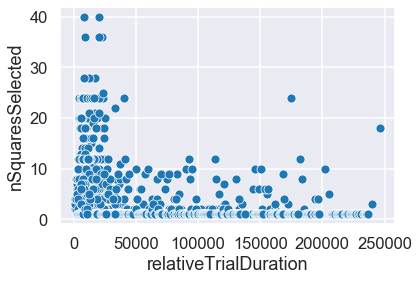

In [21]:
# how many grid-squares selected?

sns.scatterplot(data=df_color, x='relativeTrialDuration', y='nSquaresSelected')

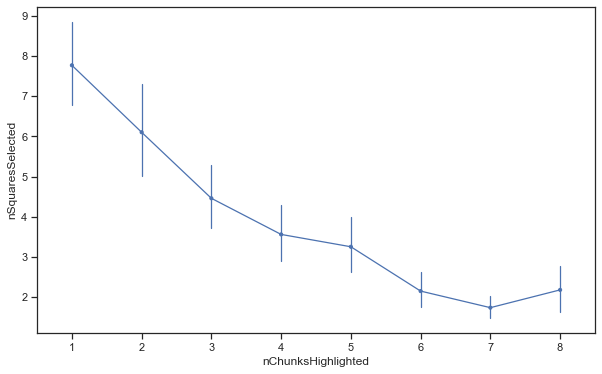

In [73]:
# do people highlight the largest chunks first?
# although- nChunksHighlighted isn't the same as finishing a chunk. 
# e.g. nChunks hilighted stays the same if you just extend a chunk a little bit. So larger n will be smaller

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.pointplot(data=df_color, x='nChunksHighlighted', y='nSquaresSelected')
#sns.swarmplot(data=df_color, x='nChunksHighlighted', y='nSquaresSelected')

## Perceptual chunks as predictors of difficulty/ complexity

### Number of perceptual chunks in each structure

This is a potential measure of structure difficulty, particularly for early trials where we expect perceptual decompositions to more strongly structure participant's plans.
I'd predict that structures with a greater number of perceptual chunks require more extensive planning.

<Figure size 720x432 with 0 Axes>

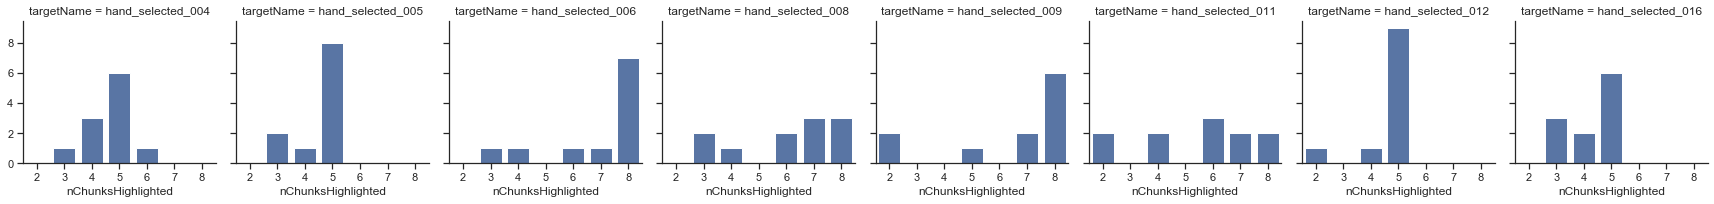

In [60]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_trial, col="targetName", col_order=targets)
g.map(sns.countplot, "nChunksHighlighted", order=range(2,9));

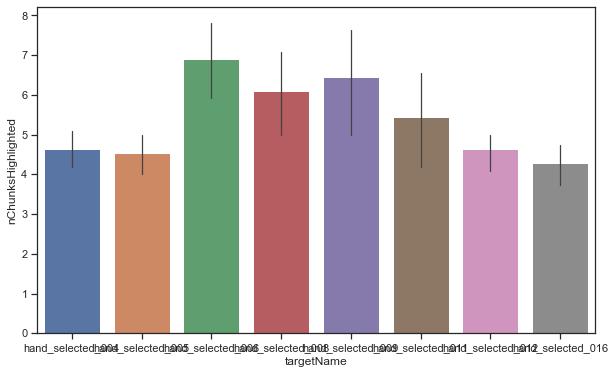

In [63]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.barplot(data=df_trial, y='nChunksHighlighted',x='targetName', order=targets)

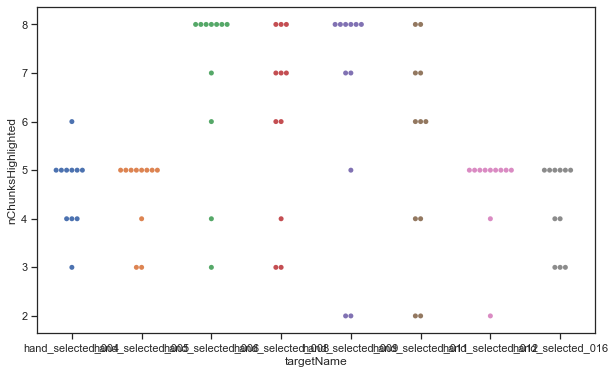

In [61]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
sns.swarmplot(data=df_trial, y='nChunksHighlighted',x='targetName', order=targets)

### Strategies for comparing perceptual chunks with procedural chunks

# From meeting with Judy

- For each structure:
    - / Get all chunks from all decompositions
    - Cluster chunks by euclidean distance (dimension for each square)
        - (first get distance matrix), then apply clustering?
        - Make heatmap of the main clusters (do we display median or exemplar or all chunks overlaid?)
    - For each chunk:
        - go through action sequences to see:
            - number of exact matches
            - ratio of contained vs. spanning 
            

this way we can avoid having to only use perfect reconstructions to identify chunks

In [108]:
df = df_trial[(df_trial.targetName==target)].reset_index()

In [114]:
df.structureGrid[1]

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 2, 2, 2, 2],
       [0, 0, 0, 0, 2, 2, 2, 2],
       [0, 0, 0, 0, 2, 2, 2, 2],
       [3, 3, 3, 3, 2, 2, 2, 2],
       [3, 3, 3, 3, 2, 2, 2, 2],
       [3, 3, 3, 3, 2, 2, 2, 2]])

In [165]:
(df.structureGrid[i]==1)*1

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1]])

#### Create distance matrices between chunks

In [166]:
def addPerceptualChunks(chunk_list, decomposition, group_number):
    '''
    Checks whether a chunk with that group number exists in the decomposition and adds it to chunk_list 
    '''
    chunk = (decomposition==group_number)*1
    if chunk.any():
        chunk_list.append(chunk)

In [171]:
# for each structure, throw all chunks from all decompositions into a giant list

perceptual_chunks = {}

for target in targets:
    
    perceptual_chunks[target] = []
    
    for group in range(1,9):
        df_trial[df_trial.targetName==target].structureGrid.apply(\
            lambda decomposition: addPerceptualChunks(perceptual_chunks[target],
                                                                        decomposition,
                                                                        group))


In [175]:
# create distance matrices between chunks within each structure

dmats = {}

for target in targets:
    
    chunks = [chunk.flatten() for chunk in perceptual_chunks[target]]
    
    dmats[target] = np.zeros((len(chunks), len(chunks)))
    
    for i, chunk_i in enumerate(chunks):
        for j, chunk_j in enumerate(chunks):
            dmats[target][i,j] = distance.euclidean(chunk_i, chunk_j)


For each structure I've got a list of all chunks from all decompositions. 
I'm now clustering these to give us something to compare to building procedures (either a median, or exemplar, or set of chunks from that cluster).
As I see it there are two sensible ways of clustering:
1. Use biclustering where k = the mean number of chunks assigned to that structure.
    - this seems intuitive and works fairly well, but in trying to assign every single chunk to a cluster it ends up with some messier clusters. It seems like a bad decision to force obscure chunks into a cluster.
2. Use affinity propagation
    - this seems the better strategy. Here we don't have to prespecify the number of chunks, and we can just throw away any clusters with few members. It also clusters by finding an exemplar, which gives us something simple to work with when comparing with procedures.


#### Cluster using biclustering, where k = mean number of chunks for that structure.
Looks cool, but probably not the best clustering method as it forces every chunk into a cluster. Maybe some chunks are completely different from the others and we'd rather throw them away.

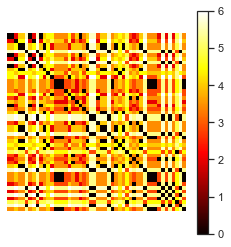

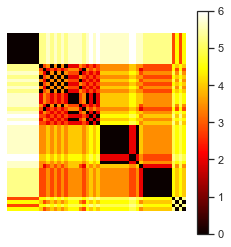

In [207]:
target = 'hand_selected_005'

# get the mean number of chunks for that structure
meanNChunks = np.round(df_trial.groupby('targetName')['nChunksHighlighted'].mean()).astype(int).to_dict()

# group into n clusters where n is the mean amount of chunks for that structure

clustering = SpectralBiclustering(n_clusters=meanNChunks[target], random_state=0).fit(dmats[target]) # https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html
order = clustering.row_labels_

sorted_rdm = dmats[target][np.argsort(clustering.row_labels_)]
sorted_rdm = sorted_rdm[:, np.argsort(clustering.column_labels_)]

img1 = plt.matshow(dmats[target])
plt.axis('off')
plt.colorbar()
img2 = plt.matshow(sorted_rdm)
plt.axis('off')
img1.set_cmap('hot')
img2.set_cmap('hot')
plt.colorbar()

#### Cluster using affinity propagation. 
Provides us with exemplar, and allows us to filter out clusters with few members

In [261]:
# create arrays (nsamples, nfeatures)

featureMats = {}

for target in targets:
    
    chunks = [chunk.flatten() for chunk in perceptual_chunks[target]]
    featureMats[target] = np.array(chunks)

In [326]:
target = 'hand_selected_009'

In [327]:
ap = AffinityPropagation().fit(featureMats[target])

In [328]:
# Explore clustering

labels = ap.labels_

cluster_centers_indices = ap.cluster_centers_indices_
cluster_centers_ = ap.cluster_centers_

n_clusters_ = len(cluster_centers_indices)

print(str(n_clusters_) + ' clusters')


13 clusters


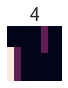

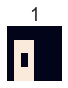

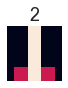

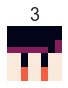

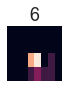

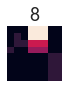

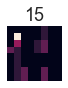

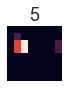

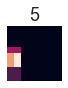

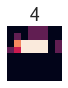

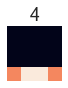

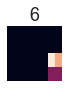

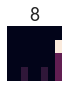

In [329]:
label = 0

for label in np.unique(labels):

    chunk_cluster = featureMats[target][labels==label,:].sum(axis=0).reshape((8,8))
    
    fig = plt.figure(figsize=(1,1))
    img1 = plt.imshow(np.rot90(chunk_cluster))
    plt.title(str(featureMats[target][labels==label,:].shape[0]))
    plt.axis('off')

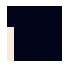

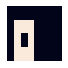

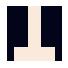

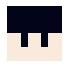

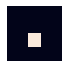

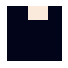

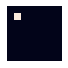

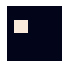

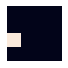

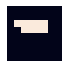

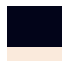

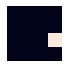

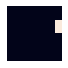

In [330]:
for exemplar in cluster_centers_:
    fig = plt.figure(figsize=(1,1))
    img1 = plt.imshow(np.rot90(exemplar.reshape((8,8))))
    plt.axis('off')

Next:

- For each chunk:
    - go through action sequences to see:
        - number of exact matches
        - ratio of contained vs. spanning
        
Somewhere I have a way of searching action sequences by world-diff, which should be the same representation as these perceptual chunks (once they've been aligned in an 18x13 gridworld)

Lots of testing needed at this stage

consider:

- construct dataframe with all world differences.
    - i.e. action 0-1, 0-2, 0-3, 1-2, 1-3, etc.
    - would be large.
    - (gameID, targetName, trialNum, rep, condition, world-diff, action_1, action_2, window)
- see if there's a match, if so +1

In [353]:
# load in procedural data from silhouette experiment

silhouette_csv_dir

procedural_path_p = os.path.join(silhouette_csv_dir,'procedural_chunks_world_states_{}.p'.format('Exp2Pilot3_all'))
proc_df = pickle.load( open(procedural_path_p, "rb" ))

In [354]:
proc_df

,trialNum,targetName,gameID,condition,blockNum,repetition,phase_extended,flatDiscreteWorld,usableDiscreteWorld,rawF1DiscreteScore,discreteWorld,flatDiscreteWorldStr,perfectScore
0,0,hand_selected_011,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,repeated,1,0,pre,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.266667,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...,False
1,0,hand_selected_011,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,repeated,2,0,pre,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.470588,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...,False
2,0,hand_selected_011,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,repeated,3,0,pre,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.555556,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...,False
3,0,hand_selected_011,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,repeated,4,0,pre,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.700000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...,False
4,0,hand_selected_011,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,repeated,5,0,pre,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.772727,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22734,23,hand_selected_004,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,repeated,5,3,post,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.594595,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...,False
22735,23,hand_selected_004,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,repeated,6,3,post,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.731707,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...,False
22736,23,hand_selected_004,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,repeated,7,3,post,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.790698,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...,False
22737,23,hand_selected_004,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,repeated,8,3,post,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0.893617,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...",0000000000000000000000000000000000000000000000...,False


In [357]:
# this method uses first and last state states of ngrams of a given length to identify chunks. 
# therefore the first state displayed below isn't a block placement. 

chunk_range = range(3,8) # number of blocks + 1 for initial state
k = 10 # take top k most frequent chunks
chunk_data = {}

# make a dataframe with a group for each reconstruction
df_target_grouped = proc_df.groupby(['gameID','targetName','repetition'])['flatDiscreteWorldStr']

for chunk_size in chunk_range:

    # Calculate the ngrams of a particular length for each reconstruction
    df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

    chunk_data[chunk_size] = {}
    chunk_data[chunk_size]['ngram_list'] = {}
    chunk_data[chunk_size]['diff'] = {}
    chunk_data[chunk_size]['diff_counts'] = {}
    chunk_data[chunk_size]['top_k_diff'] = {}

    for t in targets:
        # for each target, put the ngrams from all reconstructions into list
        chunk_data[chunk_size]['ngram_list'][t] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
        chunk_data[chunk_size]['diff'][t] = ["".join([str(a) for a in 
                      list((np.array(list(ngram[-1])).astype(np.int) - 
                         np.array(list(ngram[0])).astype(np.int)))]) for ngram in chunk_data[chunk_size]['ngram_list'][t]]
        chunk_data[chunk_size]['diff_counts'][t] = Counter(chunk_data[chunk_size]['diff'][t]) # count occurrences of each ngram across ppts
        chunk_data[chunk_size]['top_k_diff'][t] =  chunk_data[chunk_size]['diff_counts'][t].most_common(k)

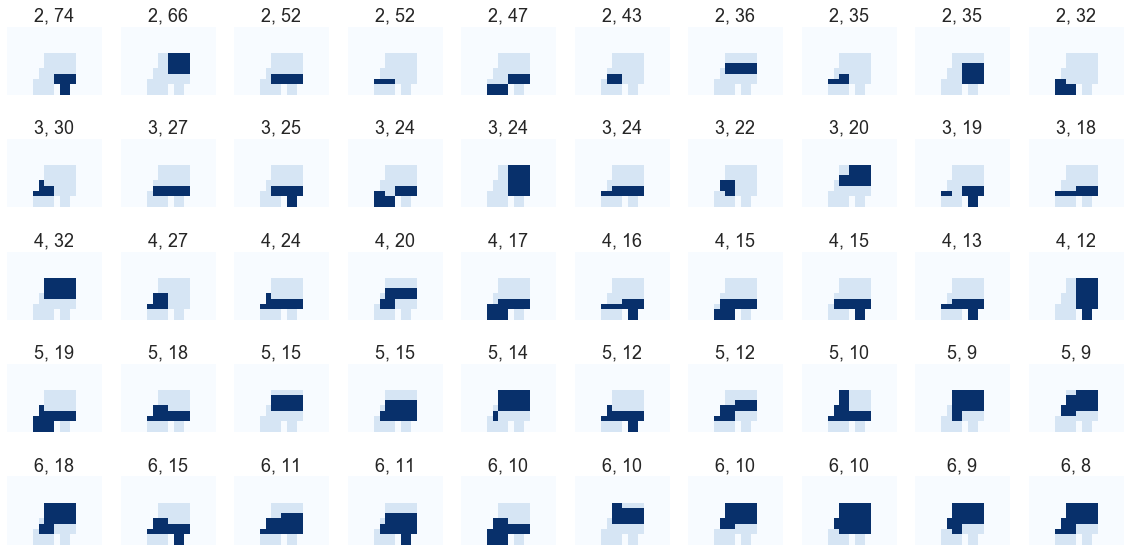

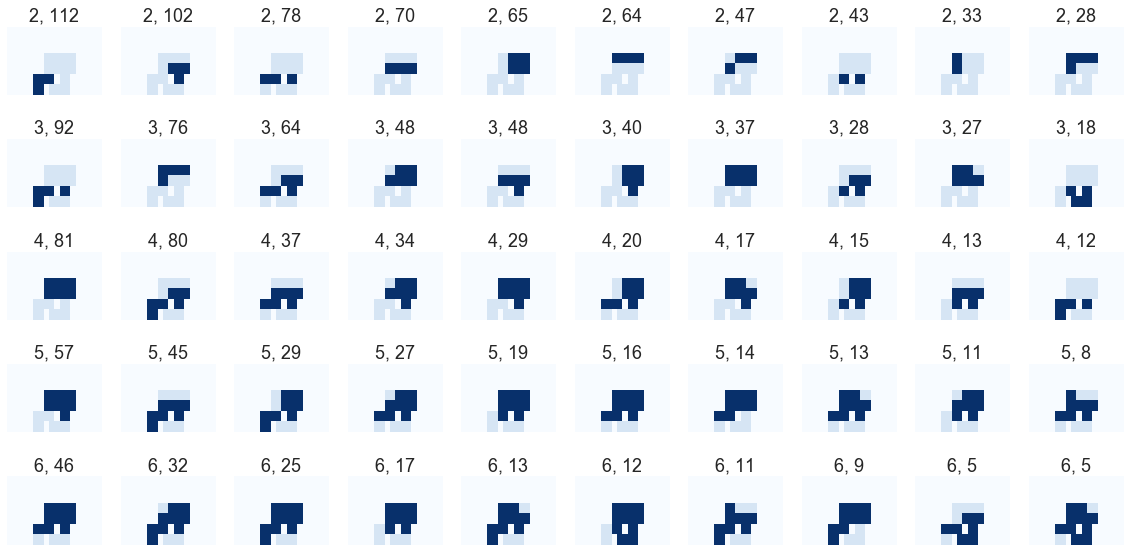

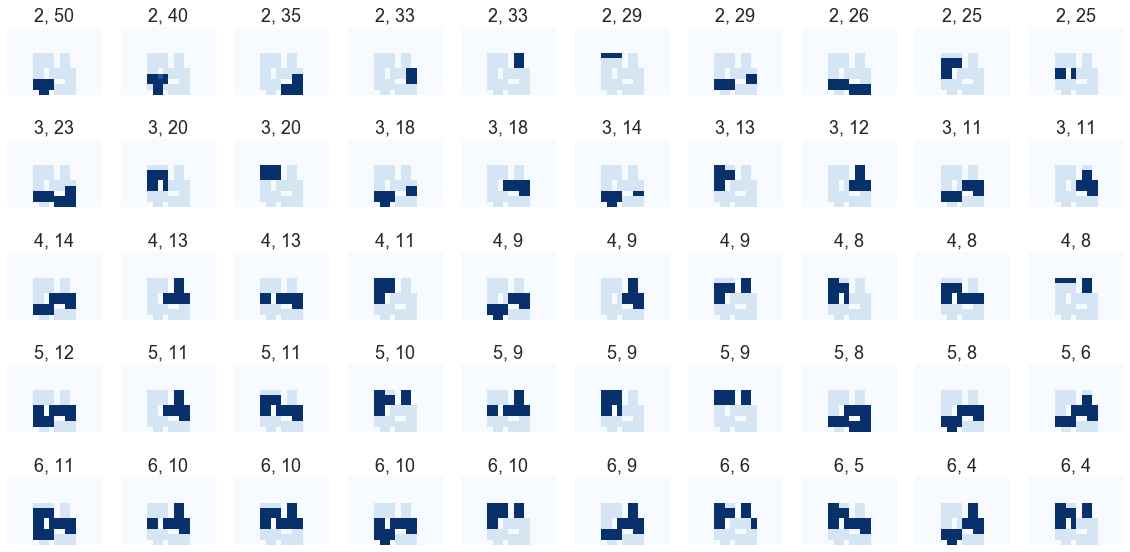

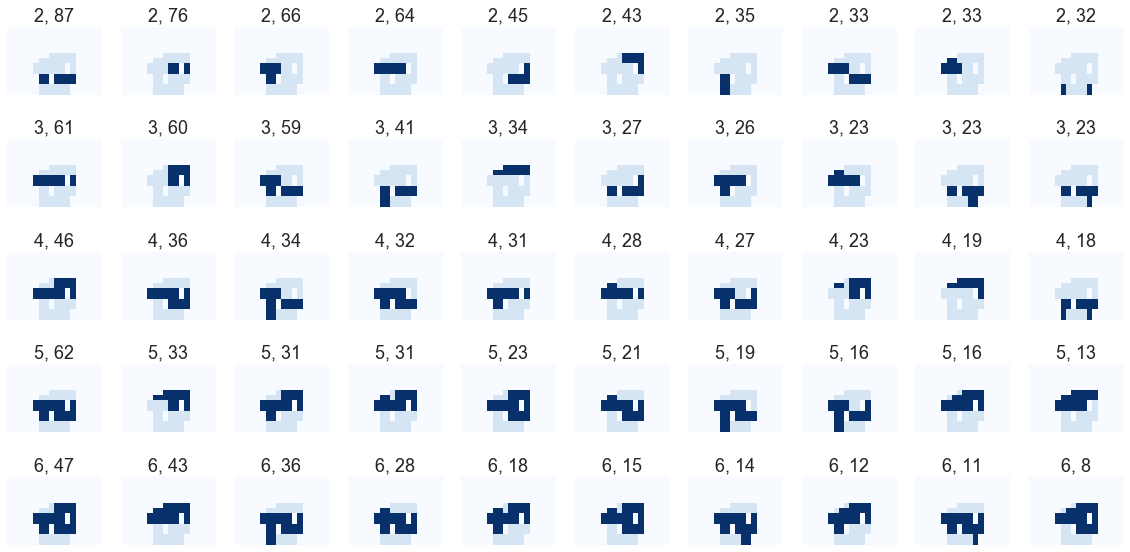

In [ ]:
## for each ngram, draw the sequence of world states in one image (minus the rest of the image)


for t in targets:

#     print('chunk size: ', chunk_size)
    fig, axs = plt.subplots(len(chunk_range), k, figsize=(20,2*len(chunk_range))) # new figure for each target

    for csi, chunk_size in enumerate(chunk_range):
        for j in range(0,k):
            states = [chunk_data[chunk_size]['top_k_diff'][t][j][0]]

            axs[csi,j].axis('off')
            axs[csi,j].set_title(str(chunk_size - 1) + ', ' + str(chunk_data[chunk_size]['top_k_diff'][t][j][1]))

            drawing.show_chunk(states, axs[csi,j], target=t)

            
